In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import torch
import h5py
import yaml
from   omegaconf import OmegaConf

from   ldm.util  import instantiate_from_config

# Instantiate model from config YAML file
config_path = "ldm/yaml_config.yaml"
config      = OmegaConf.load(config_path)
model       = instantiate_from_config(config.model)

# Load checkpoint
ckpt_path = "model.ckpt" # Unzip from https://ommer-lab.com/files/latent-diffusion/sr_bsr.zip
sd        = torch.load(ckpt_path, map_location="cpu")["state_dict"]
model.load_state_dict(sd, strict=False)

print(model)

/scratch/coop/drozda/torch-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 113.62 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
LatentDiffusion(
  (model): DiffusionWrapper(
    (diffusion_model): UNetModel(
      (time_embed): Sequential(
        (0): Linear(in_features=160, out_features=640, bias=True)
        (1): SiLU()
        (2): Linear(in_features=640, out_features=640, bias=True)
      )
      (input_blocks): ModuleList(
        (0): TimestepEmbedSequential(
          (0): Conv2d(6, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1-2): 2 x TimestepEmbedSequential(
          (0): ResBlock(
            (in_layers): Sequential(
              (0): GroupNorm32(32, 160, eps=1e-05, affine=True)
              (1): SiLU()
              (2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

In [14]:
device       = "cuda" if torch.cuda.is_available() else "cpu"
model        = model.to(device)
model.logvar = model.logvar.to(model.device)
print(f"model.device: {model.device}")

model.device: cuda:0


In [17]:
# Load JAX-CFD normalized data (range [-1,1])
# See 'data/generate.ipynb'
path       = 'data/data_normalized.h5'
hr_data    = torch.from_numpy(h5py.File(path, 'r')['hr'][:])
lr_data    = torch.from_numpy(h5py.File(path, 'r')['lr'][:])
hr_tensor  = torch.stack([hr_data for _ in range(3)], 1)     # create RGB tensor from data
lr_tensor  = torch.stack([lr_data for _ in range(3)], 1)     # create RGB tensor from data
img_idx    = 0
hr_image   = hr_tensor[img_idx].unsqueeze(0)                 # Shape becomes [1, 3, H, W]
lr_image   = lr_tensor[img_idx].unsqueeze(0).to(device)      # Shape becomes [1, 3, H, W]

In [20]:
print(hr_image.device, hr_image.shape, hr_image.dtype)
print(lr_image.device, lr_image.shape, lr_image.dtype)

cpu torch.Size([1, 3, 256, 256]) torch.float32
cuda:0 torch.Size([1, 3, 64, 64]) torch.float32


In [31]:
model.eval()

with torch.no_grad():
    # For sampling, you need:
    # - conditioning (low-res image)
    # - batch size
    # - return intermediates (optional)

    # Method 2: With DDIM sampling (common for inference)
    from ldm.ddim import DDIMSampler

    sampler = DDIMSampler(model)

    # Sample shape: [C, H, W] in latent space
    shape = (3, 64, 64)

    samples_ddim, _ = sampler.sample(
        200,  # number of steps
        1,    # batch_size
        shape,
        conditioning=lr_image
    )
    hr_ldm = model.decode_first_stage(samples_ddim)    # Decode from latent to pixel space using autoencoder
    print(f"Latent samples shape: {samples_ddim.shape}")  # Should be [1, 3,  64,  64]
    print(f"High-res LDM output shape: {hr_ldm.shape}")    # Should be [1, 3, 256, 256]

Selected timesteps for ddim sampler: [  1   6  11  16  21  26  31  36  41  46  51  56  61  66  71  76  81  86
  91  96 101 106 111 116 121 126 131 136 141 146 151 156 161 166 171 176
 181 186 191 196 201 206 211 216 221 226 231 236 241 246 251 256 261 266
 271 276 281 286 291 296 301 306 311 316 321 326 331 336 341 346 351 356
 361 366 371 376 381 386 391 396 401 406 411 416 421 426 431 436 441 446
 451 456 461 466 471 476 481 486 491 496 501 506 511 516 521 526 531 536
 541 546 551 556 561 566 571 576 581 586 591 596 601 606 611 616 621 626
 631 636 641 646 651 656 661 666 671 676 681 686 691 696 701 706 711 716
 721 726 731 736 741 746 751 756 761 766 771 776 781 786 791 796 801 806
 811 816 821 826 831 836 841 846 851 856 861 866 871 876 881 886 891 896
 901 906 911 916 921 926 931 936 941 946 951 956 961 966 971 976 981 986
 991 996]
Selected alphas for ddim sampler: a_t: tensor([9.9700e-01, 9.8941e-01, 9.8171e-01, 9.7391e-01, 9.6600e-01, 9.5799e-01,
        9.4988e-01, 9.4167e-01,

DDIM Sampler: 100%|██████████| 200/200 [00:02<00:00, 69.61it/s]

Latent samples shape: torch.Size([1, 3, 64, 64])
High-res LDM output shape: torch.Size([1, 3, 256, 256])


In [32]:
hr_ldm = hr_ldm.to("cpu")
print(hr_image.device, hr_image.shape, hr_image.dtype) # REFERENCE DATA
print(hr_ldm.device,   hr_ldm.shape,   hr_ldm.dtype)   # LDM OUTPUT

cpu torch.Size([1, 3, 256, 256]) torch.float32
cpu torch.Size([1, 3, 256, 256]) torch.float32


In [36]:
print(hr_image.max(), hr_image.min(), torch.mean(hr_image)) # REFERENCE DATA
print(hr_ldm.max(),   hr_ldm.min(),   torch.mean(hr_ldm))   # LDM OUTPUT

tensor(1.) tensor(-0.9996) tensor(0.1323)
tensor(0.9868) tensor(-0.9710) tensor(0.1388)


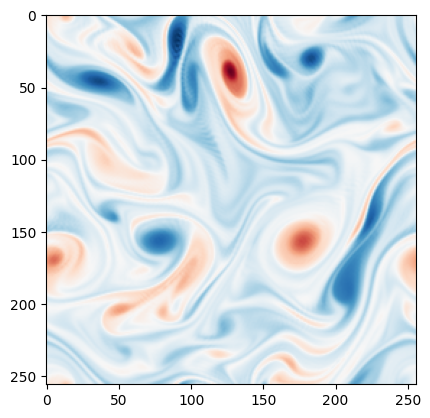

In [43]:
plt.imshow(hr_image.squeeze()[0], vmin=-1, vmax=1, cmap='RdBu')

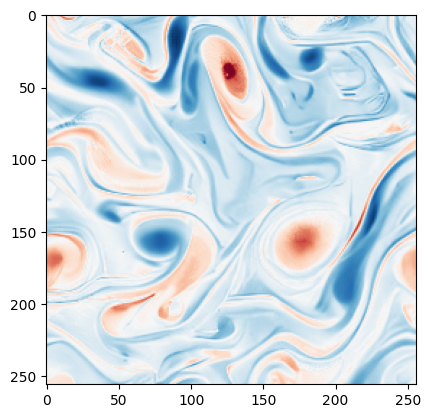

In [44]:
plt.imshow(hr_ldm.squeeze()[0], vmin=-1, vmax=1, cmap='RdBu')